In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys

In [2]:
import time
import datetime

import pandas as pd
def ends(df, x=5):
    return df.head(x).append(df.tail(x))
setattr(pd.DataFrame,'ends',ends)
setattr(pd.Series,'ends',ends)

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import itertools
import collections
from IPython.display import display
from operator import itemgetter

#plt.style.use('seaborn-white')
#plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
#plt.rc('text', usetex=True)
#plt.rc('xtick', labelsize=8)
#plt.rc('ytick', labelsize=8)
#plt.rc('axes', labelsize=16, linewidth=0.5)


#from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer, PolynomialFeatures
#from sklearn.decomposition import PCA, NMF
from sklearn.pipeline import Pipeline
#from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split


# Setting up my functions and paths

In [3]:
# My functions
from hopkinsandking import *

path_folder = os.getcwd() + "/"

# My Paths
path_fig = path_folder + 'figures/'
path_data = path_folder + 'data/'
path_outputdata = path_folder + 'outputdata/'
path_inputdata = path_folder + 'inputdata/'

# format of figures
figformat = "pdf"
save2file = False

# Reading file

In [4]:
###### LOADING THE DATA #######
filename = "df4.csv"
fnpath = path_folder + filename
longdf = pd.read_csv(fnpath, sep='\t')
print(longdf.shape)


(10000, 12)


In [5]:
longdf = longdf.loc[~(pd.isna(longdf.text))]
longdf.shape

(9997, 12)

# Cleaning the text of the train and test dataset first (for efficiency)

In [6]:
# fill-in missing category values
longdf.loc[(longdf['cpc_1_text'].isna()),'cpc_1_text'] = 'missing'

longdf.groupby('cpc_1_text').count()

,publication_number,country_code,publication_date,uspc,cpc,ipc,title,abstract,text,cpc_1,year
cpc_1_text,,,,,,,,,,,
CHEMISTRY;Metallurgy,618,618,618,618,618,618,618,618,618,618,618
ELECTRICITY,1171,1171,1171,1171,1171,1171,1171,1171,1171,1171,1171
FIXED CONSTRUCTIONS,320,320,320,320,320,320,320,320,320,320,320
GENERAL TAGGING OF NEW TECHNOLOGICAL DEVELOPMENTS,365,365,365,365,365,365,365,365,365,365,365
HUMAN NECESSITIES,1234,1234,1234,1234,1234,1234,1234,1234,1234,1234,1234
"MECHANICAL ENGINEERING,LIGHTNING,HEATING,WEAPONS,BLASTING",719,719,719,719,719,719,719,719,719,719,719
"PERFORMING OPERATIONS, TRANSPORTING",1438,1438,1438,1438,1438,1438,1438,1438,1438,1438,1438
PHYSICS,1302,1302,1302,1302,1302,1302,1302,1302,1302,1302,1302
TEXTILES;PAPER,184,184,184,184,184,184,184,184,184,184,184


In [7]:
longdf.ends(2)

,publication_number,country_code,publication_date,uspc,cpc,ipc,title,abstract,text,cpc_1,cpc_1_text,year
0,US-725177-A,US,19030414,84/320.,G10D3/163,[],Attachment for mandolins or similar instruments.,[],"PATENTED APR. 14, 1903. \n J. M. TIMMONS. \n...",G,PHYSICS,1903
1,US-725485-A,US,19030414,191/60.1,B60L5/06,[],Trolley-wheel.,[],"PATENTBD- APR. 14, 1903. \n No. 725,485.v \n...",B,"PERFORMING OPERATIONS, TRANSPORTING",1903
9998,US-D827899-S,US,20180904,D26/67.,[],[],Electronic torch,[],FIG. 1 is a isometric view of an electronic t...,NaN,missing,2018
9999,US-D828467-S,US,20180911,D21/662.,[],[],Exercise strap,[],FIG. 1 is a front perspective view of an exer...,NaN,missing,2018


In [8]:
ct = CleanText()
longdf['cleaned_text'] = ct.fit_transform(longdf['text'])

# Dividing into train/test

In [9]:
longdf_train, longdf_validation = train_test_split(longdf, test_size=0.33, random_state=42)

In [10]:
X_train = longdf_train[["cleaned_text", "cpc_1_text"]]
X_validation = longdf_validation[["cleaned_text", "cpc_1_text"]]

In [11]:
# Here, we have to be careful about what the 'target' is.
y_train = X_train.groupby(by = ['cpc_1_text']).count()
y_validation = X_validation.groupby(by = ['cpc_1_text']).count()

# Fit function

In [12]:
myanalyzer = HopkinsKingCategoryCount(col_names = ["cleaned_text", "cpc_1_text"], verbose=True)

In [13]:
myanalyzer.fit(X_train)

 ==> Finished selecting some k words and creating the matrix of P(W|C).
 ==> Access them through object.PWgC_ and object.selectedkwords_vec_
['accomplish' 'letter' 'pretreat' 'protect' 'spragu' 'longer' 'bring'
 'concern' 'capsul' 'tradit' 'mn' 'corr' 'accompani' 'spray' 'permit'
 'gram' 'increas' 'chemic' 'patent' 'vessel' 'cheaper' 'integr' 'claim'
 'disadvantag' 'balanc']


HopkinsKingCategoryCount(col_names=['cleaned_text', 'cpc_1_text'], copy=True,
             do_clean_text=False, kwords=25, min_freq=10, random_seed=None,
             sample_with_weights=True, verbose=True)

In [14]:
myanalyzer.PWgC_.ends(2)

category,CHEMISTRY;Metallurgy,ELECTRICITY,FIXED CONSTRUCTIONS,GENERAL TAGGING OF NEW TECHNOLOGICAL DEVELOPMENTS,HUMAN NECESSITIES,"MECHANICAL ENGINEERING,LIGHTNING,HEATING,WEAPONS,BLASTING","PERFORMING OPERATIONS, TRANSPORTING",PHYSICS,TEXTILES;PAPER,missing
wordcombination,,,,,,,,,,
0000000000000000000000000,0.099057,0.110414,0.018018,0.17551,0.045122,0.091503,0.060041,0.07854,0.042735,0.585198
0000000000000000000000001,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.001035,0.00000,0.000000,0.000574
1111101110001111011010001,0.000000,0.000000,0.000000,0.00000,0.001220,0.000000,0.000000,0.00000,0.000000,0.000000
1111101110111001011010001,0.002358,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


In [15]:
myanalyzer.PWgC_.sum(axis=0)

category
CHEMISTRY;Metallurgy                                         1.0
ELECTRICITY                                                  1.0
FIXED CONSTRUCTIONS                                          1.0
GENERAL TAGGING OF NEW TECHNOLOGICAL DEVELOPMENTS            1.0
HUMAN NECESSITIES                                            1.0
MECHANICAL ENGINEERING,LIGHTNING,HEATING,WEAPONS,BLASTING    1.0
PERFORMING OPERATIONS, TRANSPORTING                          1.0
PHYSICS                                                      1.0
TEXTILES;PAPER                                               1.0
missing                                                      1.0
dtype: float64

# Predict function

In [16]:
N_per_C = myanalyzer.predict(X_validation)

There are 795 word combinations in test missing in training set.
That is, 837 documents in test.
These represent a fraction of 0.25 documents in test.
 ==> Finished counting documents given the k words selected, and estimating counts per category (returned).
 ==> Access them through object.N_per_C_


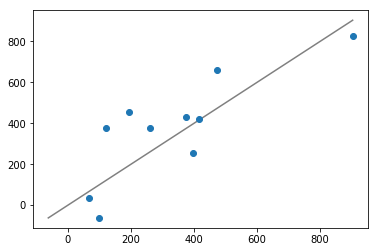

In [17]:
xline = np.linspace(np.min(np.concatenate([y_validation['cleaned_text'].values, N_per_C.values])), 
                    np.max(np.concatenate([y_validation['cleaned_text'].values, N_per_C.values])))
plt.plot(xline, xline, color='gray')
plt.plot(y_validation.values, N_per_C.values, marker='o', linestyle='None')
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error

In [19]:
np.sqrt(mean_squared_error(y_validation, N_per_C))

154.44495993031165

# How many k in k-words is good? Implementing Cross-Validation

### Dividing into train/test

In [93]:
longdf_train, longdf_validation = train_test_split(longdf, test_size=0.20, random_state=1234)

In [94]:
X_train = longdf_train[["cleaned_text", "cpc_1_text"]]
X_validation = longdf_validation[["cleaned_text", "cpc_1_text"]]

In [95]:
# Here, we have to be careful about what the 'target' is.
y_train = X_train.groupby(by = ['cpc_1_text']).count()
y_validation = X_validation.groupby(by = ['cpc_1_text']).count()

### Exploring all parameter combinations

In [96]:
# Range of possible parameters
candidates_parameters = {'kwords': [15, 20, 25, 35, 50, 75, 100], 
                         'min_freq': [20, 40, 80, 120, 160, 320, 640],
                        'sample_with_weights': [True, False]}

In [97]:
best_hkparams = hopkinsking_GridSearchCV(X_train, col_names = ["cleaned_text", "cpc_1_text"], 
                                         params_multiple_vals = candidates_parameters, 
                                         num_splits=5, doprint=True)

Evaluating parameter combination #1
Evaluating parameter combination #2
Evaluating parameter combination #3
Evaluating parameter combination #4
Evaluating parameter combination #5
Evaluating parameter combination #6
Evaluating parameter combination #7
Evaluating parameter combination #8
Evaluating parameter combination #9
Evaluating parameter combination #10
Evaluating parameter combination #11
Evaluating parameter combination #12
Evaluating parameter combination #13
Evaluating parameter combination #14
Evaluating parameter combination #15
Evaluating parameter combination #16
Evaluating parameter combination #17
Evaluating parameter combination #18
Evaluating parameter combination #19
Evaluating parameter combination #20
Evaluating parameter combination #21
Evaluating parameter combination #22
Evaluating parameter combination #23
Evaluating parameter combination #24
Evaluating parameter combination #25
Evaluating parameter combination #26
Evaluating parameter combination #27
Evaluating

In [98]:
best_hkparams

{'kwords': 20, 'min_freq': 80, 'sample_with_weights': True}

# Given best hyper-parameters, bootstrap the estimation

In [99]:
num_samplings = 100
estimated_vecs = np.zeros((len(y_train), num_samplings))
myanalyzer_i = HopkinsKingCategoryCount(col_names = ["cleaned_text", "cpc_1_text"], **best_hkparams)
for i in range(num_samplings):
    # In order to sample different k-words, I need to fit the data within the loop
    myanalyzer_i.fit(X_train)
    N_per_C_i = myanalyzer_i.predict(X_validation)
    estimated_vecs[:,i] = N_per_C_i

In [100]:
estimated_widedf = pd.DataFrame(estimated_vecs, index=y_train.index, 
                            columns = [f"sim{i+1}" for i in range(num_samplings)]).reset_index()
estimated_widedf['pC_true'] = y_validation.values

estimated_longdf = estimated_widedf.melt(id_vars = ['cpc_1_text', 'pC_true'], 
                                         var_name = 'simulation', value_name = 'pC_est')

In [101]:
estimated_longdf.ends(2)

,cpc_1_text,pC_true,simulation,pC_est
0,CHEMISTRY;Metallurgy,133,sim1,22.480383
1,ELECTRICITY,231,sim1,91.044462
998,TEXTILES;PAPER,35,sim100,29.723794
999,missing,507,sim100,508.672486


C:\Users\agomez\AppData\Local\Continuum\Anaconda3\envs\machinelearning\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


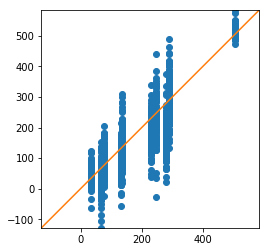

In [106]:
xline = np.linspace(estimated_longdf['pC_est'].min(), 
                    estimated_longdf['pC_est'].max())

plt.plot(estimated_longdf.pC_true.values, estimated_longdf.pC_est.values, marker='o', linestyle='None')
plt.plot(xline, xline)
plt.ylim(estimated_longdf['pC_est'].min(),estimated_longdf['pC_est'].max())
plt.xlim(estimated_longdf['pC_est'].min(),estimated_longdf['pC_est'].max())
plt.axes().set_aspect('equal')
plt.show()

C:\Users\agomez\AppData\Local\Continuum\Anaconda3\envs\machinelearning\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


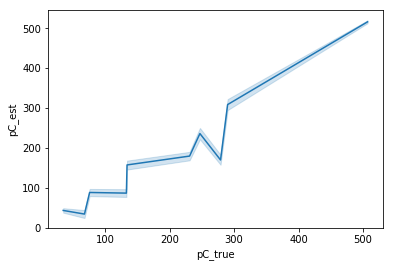

In [103]:
sns.lineplot(x='pC_true', y='pC_est', data=estimated_longdf)

In [104]:
pred_mean = pd.DataFrame([y_validation['cleaned_text'].values,
                          np.mean(estimated_vecs, axis=1),
                          np.std(estimated_vecs, axis=1)/np.sqrt(estimated_vecs.shape[1])],
                         index = ['true', 'mean', 'std_error'],
                         columns = y_train.index).T

In [105]:
pred_mean

,true,mean,std_error
cpc_1_text,,,
CHEMISTRY;Metallurgy,133.0,87.168357,4.765968
ELECTRICITY,231.0,179.938988,5.800367
FIXED CONSTRUCTIONS,76.0,88.783769,4.480867
GENERAL TAGGING OF NEW TECHNOLOGICAL DEVELOPMENTS,68.0,34.707844,5.096855
HUMAN NECESSITIES,247.0,236.306775,7.208371
"MECHANICAL ENGINEERING,LIGHTNING,HEATING,WEAPONS,BLASTING",134.0,157.737309,5.645184
"PERFORMING OPERATIONS, TRANSPORTING",290.0,308.946071,7.110033
PHYSICS,279.0,170.203157,6.197847
TEXTILES;PAPER,35.0,43.809666,2.897162
